In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci
import blackjax

from pyia import GaiaData

In [2]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

In [3]:
with open(cache_path / 'joint-model.pkl', 'rb') as f:
    JointModel, res_pars = pickle.load(f)

model has 322 parameters


In [4]:
run_data = at.Table.read(cache_path / 'run_data.fits')
run_data = {k: np.array(run_data[k]) for k in run_data.colnames}

In [5]:
# g = GaiaData(
#     at.join(
#         at.Table.read(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits'),
#         at.Table.read(cache_path / 'optimized-member-prob.fits'), 
#         keys='source_id'
#     )
# )

In [14]:
opt_p = JointModel.pack_pars(JointModel.pack_component_pars(res_pars))

## Testings NUTS w/o window adaptation

In [22]:
inv_mass_matrix = np.full_like(opt_p, 0.5)
step_size = 1e-3

fn = jax.tree_util.Partial(JointModel.ln_posterior, data=run_data)
nuts = blackjax.nuts(fn, step_size, inv_mass_matrix)

In [24]:
initial_state = nuts.init(opt_p)
# initial_state

In [25]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [26]:
%%time
rng_key = jax.random.PRNGKey(0)
states = inference_loop(rng_key, nuts.step, initial_state, 10)

2022-10-11 08:51:11.129462: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m2.280768535s

********************************
[Compiling module jit_prim_fun.29] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


CPU times: user 5min 34s, sys: 1.2 s, total: 5min 35s
Wall time: 5min 34s


In [30]:
nuts.step(rng_key, initial_state)

2022-10-11 09:07:14.965427: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_prim_fun.41] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-10-11 09:07:36.174814: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m21.209462992s

********************************
[Compiling module jit_prim_fun.41] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


(HMCState(position=DeviceArray([ 6.64484712e+00,  5.88646244e+00,  5.72286280e+00,
               5.66497201e+00,  5.72198619e+00,  5.76512150e+00,
               5.91454288e+00,  6.13527106e+00,  6.26476156e+00,
               4.32393384e-01,  8.50570250e-01,  5.06153226e-01,
               4.73506659e-01,  2.96962127e-01,  7.97582234e-01,
               3.55822241e-01,  2.00000000e+01,  2.00000000e+01,
               2.00000000e+01,  1.99855651e+01,  1.98491566e+01,
               2.00000000e+01,  2.00000000e+01,  1.98577892e+01,
               1.99694377e+01,  2.00000000e+01,  2.00000000e+01,
               2.00000000e+01,  2.00000000e+01,  1.99248938e+01,
               1.73313603e+00,  1.65450301e+00,  1.69638233e+00,
               1.62783461e+00,  1.65087289e+00,  1.81029640e+00,
               1.48522113e+00,  1.73162685e+00,  2.04517238e+00,
               1.82392570e+00,  2.01162248e+00,  1.92661138e+00,
               1.95993255e+00,  2.50511343e+00,  9.54168756e-01,
       

Text(0, 0.5, 'parameter value')

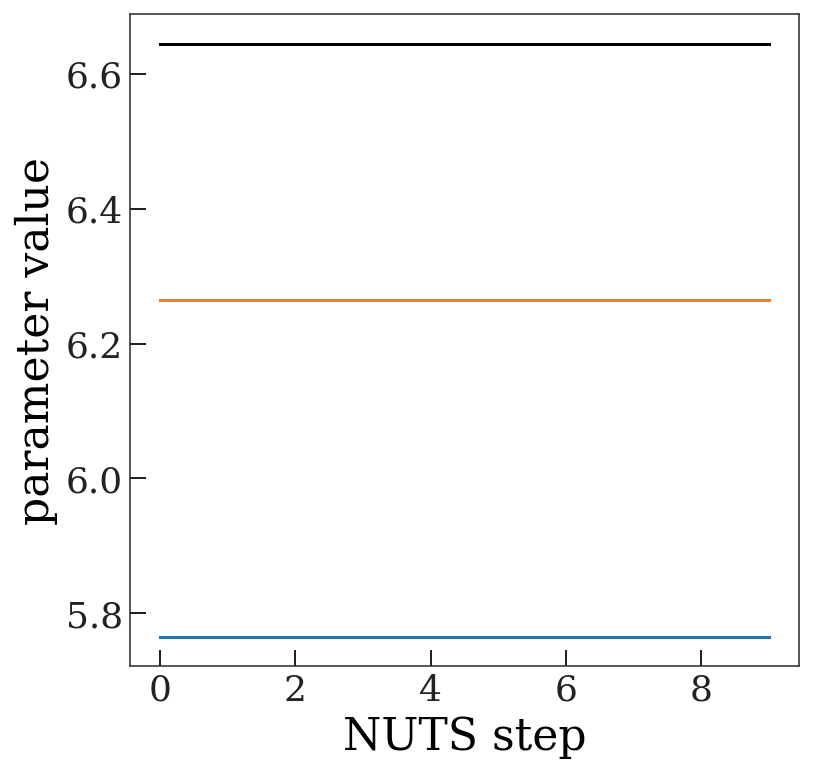

In [28]:
for i in [0, 5, 8]:
    plt.plot(states.position[:, i], marker="", drawstyle="steps-mid")

plt.xlabel("NUTS step")
plt.ylabel("parameter value")

## NUTS Sampling

In [6]:
# This is the main loop that does the sampling for us:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [ ]:
rng_key = jax.random.PRNGKey(42)

fn = jax.tree_util.Partial(JointModel.ln_posterior, data=run_data)
warmup = blackjax.window_adaptation(
    blackjax.nuts,
    fn,
    101,
)
state, kernel, _ = warmup.run(
    rng_key,
    opt_p,
)

2022-10-10 15:27:43.783025: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_prim_fun.16] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-10-10 15:29:08.746869: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m24.963904409s

********************************
[Compiling module jit_prim_fun.16] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [10]:
state

HMCState(position=DeviceArray([ 6.64484712e+00,  5.88646244e+00,  5.72286280e+00,
              5.66497201e+00,  5.72198619e+00,  5.76512150e+00,
              5.91454288e+00,  6.13527106e+00,  6.26476156e+00,
              4.32393384e-01,  8.50570250e-01,  5.06153226e-01,
              4.73506659e-01,  2.96962127e-01,  7.97582234e-01,
              3.55822241e-01,  2.00000000e+01,  2.00000000e+01,
              2.00000000e+01,  1.99855651e+01,  1.98491566e+01,
              2.00000000e+01,  2.00000000e+01,  1.98577892e+01,
              1.99694377e+01,  2.00000000e+01,  2.00000000e+01,
              2.00000000e+01,  2.00000000e+01,  1.99248938e+01,
              1.73313603e+00,  1.65450301e+00,  1.69638233e+00,
              1.62783461e+00,  1.65087289e+00,  1.81029640e+00,
              1.48522113e+00,  1.73162685e+00,  2.04517238e+00,
              1.82392570e+00,  2.01162248e+00,  1.92661138e+00,
              1.95993255e+00,  2.50511343e+00,  9.54168756e-01,
              7.983162

In [11]:
states = inference_loop(rng_key, kernel, state, 10)

2022-10-10 21:05:56.261695: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m7.754814337s

********************************
[Compiling module jit_prim_fun.19] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Text(0, 0.5, 'parameter value')

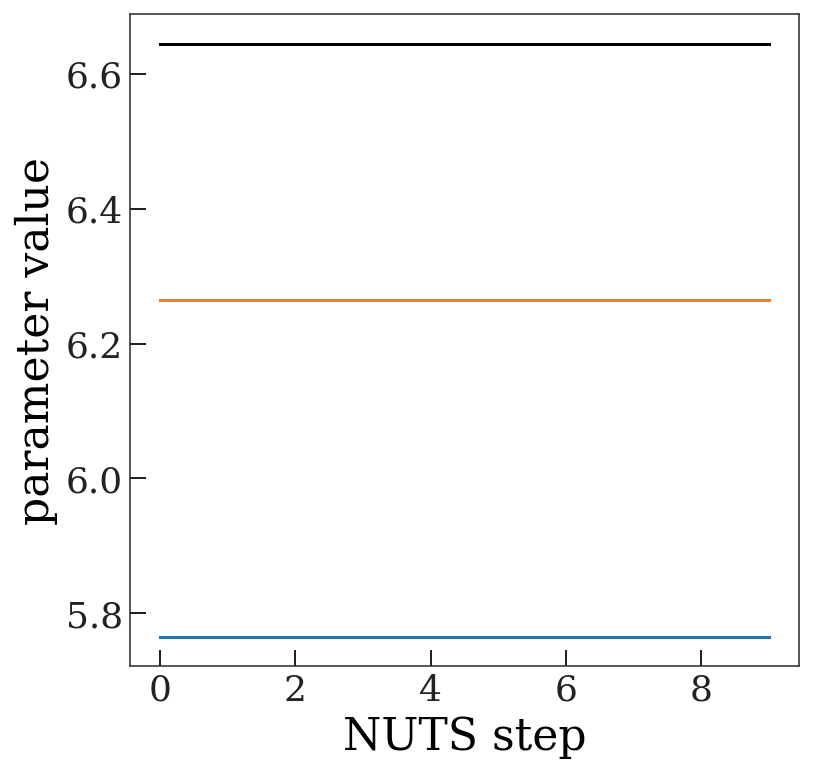

In [12]:
for i in [0, 5, 8]:
    plt.plot(states.position[:, i], marker="", drawstyle="steps-mid")

plt.xlabel("NUTS step")
plt.ylabel("parameter value")

In [26]:
np.std(states.position, axis=0)

DeviceArray([6.55860983e-11, 1.19072218e-10, 1.68898227e-10,
             2.24656840e-10, 2.01769881e-10, 1.36719355e-10,
             7.37428130e-11, 8.77815595e-11, 1.90180915e-10,
             1.63196364e-10, 8.95498455e-11, 2.18017323e-10,
             1.20288565e-10, 8.31278954e-11, 2.81053151e-10,
             1.40747748e-10, 9.31602309e-11, 1.07500219e-10,
             5.39927363e-11, 1.12930185e-10, 1.41085408e-10,
             1.16946228e-10, 3.81307393e-11, 9.00275156e-11,
             6.20844486e-11, 8.22074092e-11, 5.23633646e-11,
             1.33476170e-10, 2.30439543e-10, 9.93017358e-11,
             1.07853591e-10, 8.97334538e-11, 1.33082613e-10,
             7.20566533e-11, 1.75963832e-10, 2.61949652e-10,
             1.31393305e-10, 1.26298351e-10, 7.29876374e-11,
             1.29694575e-10, 1.75698347e-10, 2.55270540e-10,
             1.27915324e-10, 1.37421189e-10, 7.91380614e-11,
             7.62406919e-11, 1.05535112e-10, 1.18182061e-10,
             1.11692975e

TODO: convergence checks and all that...

Save output files: